In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50, resnet34
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.cuda.amp as amp 
import pandas as pd
import os
from PIL import Image

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt


In [9]:
# Define dataset and dataloaders
class DatasetGenerator(Dataset):
    def __init__(self, data_frame, root_dir, nnTarget, transform=None):
        self.data_frame = pd.read_csv(data_frame)
        self.target = nnTarget
        self.listImagePaths = list(root_dir + self.data_frame['Path'])
        self.listImageLabels = list(self.data_frame[nnTarget])
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        imagePath = self.listImagePaths[index]
        imageData = Image.open(imagePath).convert('RGB')

        label = self.listImageLabels[index]
        # Define a dictionary to map class labels to class indices
        class_to_idx = {
            'PA': 0,
            'AP': 1,
        }
        imageLabel = class_to_idx[label]
        if self.transform != None: imageData = self.transform(imageData)

        return imageData, imageLabel

# Define preprocessing transformations
validate_transform = transforms.Compose([
    transforms.Resize((320, 320)),                   # Resize the input image to 256x256
    transforms.CenterCrop(320),               # Crop the center 224x224 portion of the image
    transforms.ToTensor(),                    # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

test_dataset = DatasetGenerator('../cheXpert-race/test_df.csv', '../', 'AP/PA', transform=validate_transform) 
pathModel = 'models/CHEXPERT_AP_RESNET34_PY_20230908-050057_epoch:006_val_loss:0.03.pth.tar'
checkpoint = torch.load(pathModel)

model = resnet34(pretrained=True)
num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.cuda()

model.load_state_dict(checkpoint['state_dict'])
model.eval()

/home/aas926/miniconda3/envs/xray_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aas926/miniconda3/envs/xray_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def parse_predictions(predictions_str):
    # Remove brackets and split the string, then convert to floats
    return [float(val) for val in predictions_str.strip('[]').split()]

In [13]:
csv_file_path = 'predictions/CHEXPERT_AP_RESNET34_PY_20230908-050057_epoch:006_val_loss:0.03_test_pred.csv'

if os.path.exists(csv_file_path):
    print('CSV file already exists')
    # Apply the custom function to convert the 'Predictions' column
    df_ap = pd.read_csv(csv_file_path)
    df_ap['Predictions'] = df_ap['Predictions'].apply(parse_predictions)
else: 
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, num_workers=5, shuffle=False, pin_memory=True)

    val_total = 0
    val_correct = 0 
    test_predictions = []  # Store predicted probabilities for AUROC and PR-AUC
    test_labels = [] 
        
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            outputs = model(inputs)
            
            probs = torch.nn.functional.sigmoid(outputs)
            predicted_classes = (probs > 0.5).float()  # Convert to binary predictions (0 or

            val_total += labels.size(0)
            val_correct += torch.sum(predicted_classes==labels).item()

            # Collect predicted probabilities and labels for AUROC and PR-AUC
            test_predictions.extend(probs.cpu().numpy())  # Assuming you have 2 classes, using probabilities of class 1
            test_labels.extend(labels.cpu().numpy())

    val_accuracy = val_correct / val_total

    # Calculate AUROC and PR-AUC
    label_binarizer = LabelBinarizer().fit(test_labels)
    y_onehot_test = label_binarizer.transform(test_labels)

    auroc = roc_auc_score(y_onehot_test, test_predictions, multi_class='ovr', average='micro')
    pr_auc = average_precision_score(y_onehot_test, test_predictions)

    print('Test AUROC: ', auroc, 'Test PR_AUC: ', pr_auc)
    data = {'Predictions': test_predictions, 'Target': test_labels}
    df = pd.DataFrame(data)

    # Specify the CSV file path
    csv_file_path = pathModel.split('models/')[1].split('.pth.tar')[0] + '_test_pred.csv'
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)

CSV file already exists


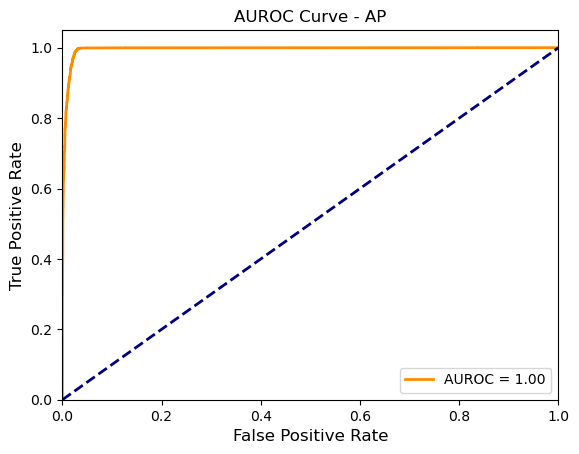

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Function to calculate AUROC and plot ROC curve
def plot_roc_curve(predictions, targets, title):
    # Binarize the targets for multiclass AUROC
    targets_ = label_binarize(targets, classes=np.unique(targets))
    n_classes = targets_.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if n_classes > 1:
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(targets_[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves for each class
        plt.figure()
        colors = ['darkorange', 'cornflowerblue', 'purple']  # Add more colors if needed
        classes = ['Asian', 'White', 'Black']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{classes[i]} (AUROC = {roc_auc[i]:.2f})')
    else:
        targets = np.array(df_ap['Target'])
        # Flatten the 'Predictions' column and convert it to a numpy array
        predictions = np.concatenate(df_ap['Predictions']).astype(float)
        fpr, tpr, _ = roc_curve(targets, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate',  fontsize = 12)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot AUROC curves for each dataframe
# For df_race, you don't need to convert it to binary
plot_roc_curve(df_ap['Predictions'], df_ap['Target'], "AUROC Curve - AP")
